In [1]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import tqdm
import tensorboardX
import logging
import os
import time
import random
import tifffile

In [2]:
# set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# set hyperparameters
batch_size = 512
learning_rate = 1e-3
num_epochs = 500
latent_dim = 2
hidden_dim = 400
input_dim = 784*4

# num_classes = 4

time_stamp = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())

checkpoint_dir = os.path.join('checkpoints', time_stamp)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

log_dir = os.path.join('logs', time_stamp)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.addHandler(logging.FileHandler(os.path.join(log_dir, 'log.txt')))
logger.info('device: {}'.format(device))
logger.info('batch_size: {}'.format(batch_size))
logger.info('learning_rate: {}'.format(learning_rate))
logger.info('num_epochs: {}'.format(num_epochs))
logger.info('latent_dim: {}'.format(latent_dim))
logger.info('hidden_dim: {}'.format(hidden_dim))
logger.info('input_dim: {}'.format(input_dim))
# logger.info('num_classes: {}'.format(num_classes))

writer = tensorboardX.SummaryWriter(log_dir)

# tensorboard --logdir=logs --port=6006


2023-07-13 09:53:29,573 - INFO - device: cuda
2023-07-13 09:53:29,574 - INFO - batch_size: 512
2023-07-13 09:53:29,574 - INFO - learning_rate: 0.001
2023-07-13 09:53:29,575 - INFO - num_epochs: 500
2023-07-13 09:53:29,575 - INFO - latent_dim: 2
2023-07-13 09:53:29,576 - INFO - hidden_dim: 400
2023-07-13 09:53:29,576 - INFO - input_dim: 3136


c:\Users\hx57\AppData\Local\anaconda3\envs\jra\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 28, 28]) torch.float32


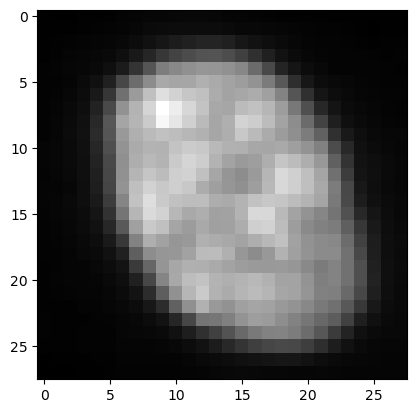

In [5]:
# load data
data_path = os.path.join(os.getcwd(), 'data/single_cell_data/')
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize((28, 28))])



class CellDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data_path = data_path
        self.data = os.listdir(data_path)
        self.data.sort()
        self.data = [os.path.join(data_path, i) for i in self.data]

    def __len__(self):
        return len(self.data)
    15:05:27
    
    def __getitem__(self, idx):
        img = tifffile.imread(self.data[idx])
        # print(self.data[idx])
        img = np.transpose(img, (1, 2, 0))
        # print(img.shape)
        min_val = np.min(img)
        max_val = np.max(img)
        normalized_image = (img - min_val) / (max_val - min_val)
        normalized_image = normalized_image.astype(np.float32)
        # img = img / np.max(img)
        # img = img.reshape(1, 64, 64)
        if self.transform:
            img = self.transform(normalized_image)
        return img
    
dataset = CellDataset(data_path, transform=trans)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# test CellDataset
for i in range(1):
    img = dataset[i]
    print(img.shape, img.dtype)
    plt.imshow(img[0], cmap='gray')
    plt.show()


In [6]:
# define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # mu and logvar
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
    
# test VAE model
for i, (img) in enumerate(dataloader):
    img = img.to(device)
    print(img.dtype)
    img = img.view(-1, input_dim)
    print(img.shape)
    out, mu, logvar = model(img)
    print(img.shape)
    print(out.shape)
    print(mu.shape)
    print(logvar.shape)
    break

torch.float32
torch.Size([512, 3136])
torch.Size([512, 3136])
torch.Size([512, 3136])
torch.Size([512, 2])
torch.Size([512, 2])


In [7]:
# define loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [8]:
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# train model
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for i, data in tqdm.tqdm(enumerate(dataloader)):
        data = data.view(-1, input_dim).to(device)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % (len(dataloader)//5) == 0:
            writer.add_scalar('loss', loss.item(), epoch*len(dataloader)+i)
            logger.info('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))
            # print('Epoch: [{}/{}], Step: [{}/{}], Loss: {}'.format(epoch+1, num_epochs, i+1, len(dataloader), loss.item()))

    writer.add_scalar('total_loss', total_loss, epoch)
    logger.info('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    # print('Epoch: [{}/{}], Total Loss: {}'.format(epoch+1, num_epochs, total_loss))
    
    # save model
    if (epoch+1) % 10 == 0:
        writer.add_image('original', data[0].view(4, 28, 28)[0].unsqueeze(0), epoch+1)
        writer.add_image('reconstruction', recon_batch[0].view(4, 28, 28)[0].unsqueeze(0), epoch+1)
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'VAE_Epoch_{}_Loss_{}.pth'.format(epoch+1, total_loss)))
        logger.info('Save model at epoch {}'.format(epoch+1))
        tifffile.imwrite(os.path.join(log_dir, 'original_{}.tif'.format(epoch+1)), data[0].view(4, 28, 28).cpu().numpy())
        tifffile.imwrite(os.path.join(log_dir, 'reconstruction_{}.tif'.format(epoch+1)), recon_batch[0].view(4, 28, 28).cpu().detach().numpy())

# close writer
writer.close()

#close logger
logger.removeHandler(logger.handlers[0])

0it [00:00, ?it/s]2023-07-13 09:53:32,277 - INFO - Epoch: [1/500], Step: [1/148], Loss: 1127294.875
29it [00:11,  2.55it/s]2023-07-13 09:53:43,646 - INFO - Epoch: [1/500], Step: [30/148], Loss: 744657.625
58it [00:22,  2.58it/s]2023-07-13 09:53:55,192 - INFO - Epoch: [1/500], Step: [59/148], Loss: 728155.3125
87it [00:34,  2.46it/s]2023-07-13 09:54:07,102 - INFO - Epoch: [1/500], Step: [88/148], Loss: 686687.25
116it [00:45,  2.62it/s]2023-07-13 09:54:18,290 - INFO - Epoch: [1/500], Step: [117/148], Loss: 725729.0625
145it [00:57,  2.63it/s]2023-07-13 09:54:29,547 - INFO - Epoch: [1/500], Step: [146/148], Loss: 696853.125
148it [00:58,  2.55it/s]
2023-07-13 09:54:30,159 - INFO - Epoch: [1/500], Total Loss: 107715331.71875
0it [00:00, ?it/s]2023-07-13 09:54:30,437 - INFO - Epoch: [2/500], Step: [1/148], Loss: 738766.8125
29it [00:07,  3.88it/s]2023-07-13 09:54:37,971 - INFO - Epoch: [2/500], Step: [30/148], Loss: 722636.8125
58it [00:15,  3.90it/s]2023-07-13 09:54:45,786 - INFO - Epoch:

148it [00:37,  3.90it/s]


ValueError: 'c' argument has 75776 elements, which is inconsistent with 'x' and 'y' with size 75568.

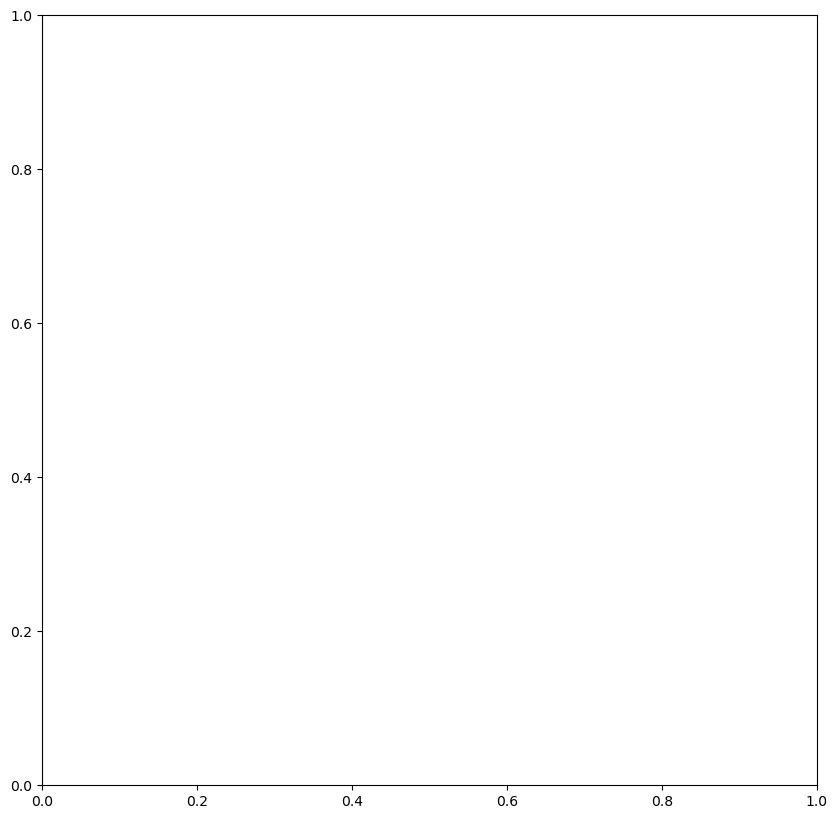

In [10]:
# # visualize latent space
# model.eval()
# with torch.no_grad():
#     for i, data in tqdm.tqdm(enumerate(dataloader)):
#         data = data.to(device)
#         recon_batch, mu, logvar = model(data)
#         if i == 0:
#             z = mu
#             label = torch.zeros(batch_size)
#         else:
#             z = torch.cat((z, mu), dim=0)
#             label = torch.cat((label, torch.zeros(batch_size)+i), dim=0)
#     z = z.cpu().numpy()
#     label = label.cpu().numpy()

# plt.figure(figsize=(10, 10))
# plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10')
# plt.colorbar()
# plt.savefig(os.path.join(log_dir, 'latent_space.png'))
# plt.show()


148it [00:42,  3.48it/s]


(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)
(3136,)


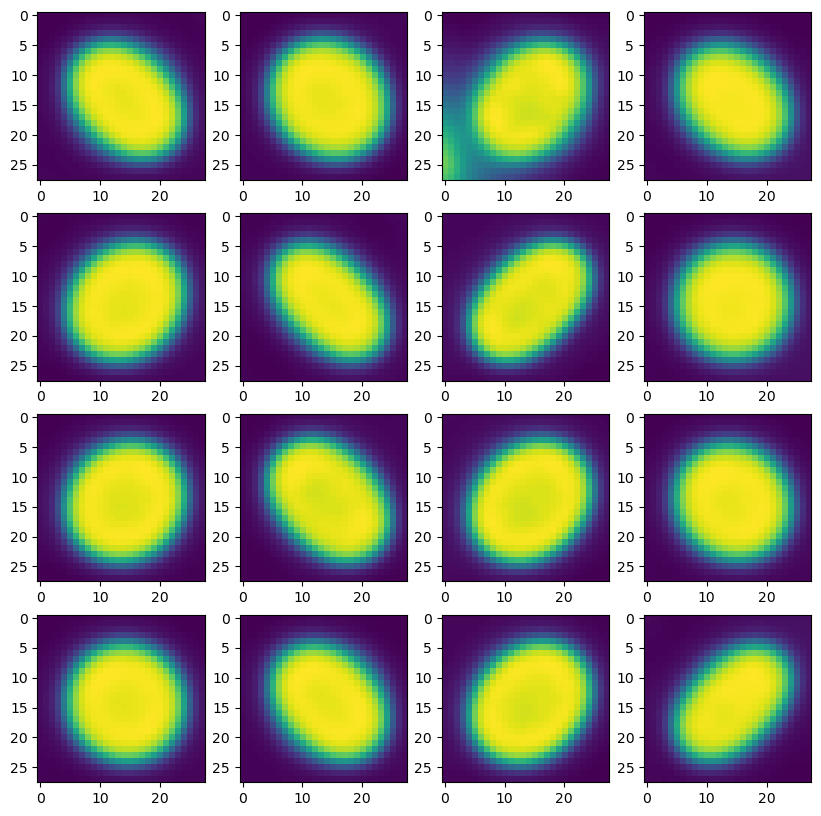

In [13]:
# visualize reconstruction
model.eval()
with torch.no_grad():
    for i, data in tqdm.tqdm(enumerate(dataloader)):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        if i == 0:
            recon = recon_batch
        else:
            recon = torch.cat((recon, recon_batch), dim=0)
    recon = recon.cpu().numpy()

plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    # print(recon[i].shape)
    plt.imshow(recon[i].reshape(4, 28, 28)[0])
plt.savefig(os.path.join(log_dir, 'reconstruction.png'))
plt.show()